<a href="https://colab.research.google.com/github/a-agmon/experiments/blob/master/ScaleSkewedDataVA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

import pandas as pd
import numpy as np


### 1. Load the data

In [30]:
df_raw = pd.read_csv("/content/drive/My Drive/capture20110810.binetflow")
#df = df_raw.sample(frac=0.2)
print(f"Data size:{len(df_raw.index)}\n")
#display(df.head(3))

Data size:2824636



In [31]:
df = df_raw.copy()
display(df.head(3))

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label
0,2011/08/10 09:46:53.047277,3550.182373,udp,212.50.71.179,39678,<->,147.32.84.229,13363,CON,0.0,0.0,12,875,413,flow=Background-UDP-Established
1,2011/08/10 09:46:53.048843,0.000883,udp,84.13.246.132,28431,<->,147.32.84.229,13363,CON,0.0,0.0,2,135,75,flow=Background-UDP-Established
2,2011/08/10 09:46:53.049895,0.000326,tcp,217.163.21.35,80,<?>,147.32.86.194,2063,FA_A,0.0,0.0,2,120,60,flow=Background


### 2. Some feature engineering ( mostly encoding categorical features and grouping less frequent data)




In [32]:
# Lets start with some preprocessing 

from sklearn import preprocessing

# We know the infected system IP addr so lets add it 

infected_addr = "147.32.84.165"
df["Bot"] = np.where(df['SrcAddr'] == infected_addr, 1, 0)

from sklearn import preprocessing

# Drop unnecessary columns
df = df.drop(columns=['SrcAddr', 'DstAddr', 'TotBytes', 'Sport', 'Dport', 'StartTime', 'sTos', 'dTos', "Label"])

# fill nulls
for feature_name in df.columns:
    if df[feature_name].isnull().values.sum() > 0:
        val = "none" if df[feature_name].dtypes == object else -1
        print(f"Filling nulls with value:{val} in column:{feature_name}")
        df[feature_name] = df[feature_name].fillna(value=val)


# define some encoding functions
def encode_field(_df, field):
    encoder = preprocessing.LabelEncoder()
    print(f"encoding field:{field}")
    return encoder.fit_transform(_df[field])


def hot_encode(_df, feature):
    return pd.get_dummies(
        encode_field(_df, feature), prefix=feature, drop_first=True)


def group_less_frequent_values(_df, feature, min_prc):
    categories = _df[feature].value_counts()
    for category in categories.index:
        # how many times this category shows in the DS?
        freq = categories[category]
        # if less than what we want (min_prc)
        if (freq < min_prc):
            new_val = "LF" if _df[feature].dtypes == object else 99
            _df.loc[_df[feature] == category, feature] = new_val
    return _df




# process the categorical features
categorical_features = ['State', 'Proto', 'Dir']
# classes that are not frequent in the data (less than 1%) will be grouped.
one_p = 0.01 * len(df.index)
# loog through the categorical
for feature in categorical_features:
    # group the less frequent ones
    df = group_less_frequent_values(df, feature, one_p)
    # index and then hot encode
    df = pd.concat([df, hot_encode(df, feature)], axis=1)

## now remove what we dont need
df = df.drop(columns=categorical_features)
print("Done processing!")
display(df.head(5))


Filling nulls with value:none in column:State
encoding field:State
encoding field:Proto
encoding field:Dir
Done processing!


,Dur,TotPkts,SrcBytes,Bot,State_1,State_2,State_3,State_4,State_5,State_6,Proto_1,Proto_2,Proto_3,Dir_1,Dir_2
0,3550.182373,12,413,0,0,0,0,0,0,0,0,0,1,1,0
1,0.000883,2,75,0,0,0,0,0,0,0,0,0,1,1,0
2,0.000326,2,60,0,0,0,1,0,0,0,0,1,0,0,1
3,0.056966,3,120,0,0,0,1,0,0,0,0,1,0,0,1
4,3427.768066,42,1596,0,0,0,0,0,0,0,0,0,1,1,0


In [0]:
display(df.head(5))

,StartTime,Dur,Proto,SrcAddr,Sport,Dir,DstAddr,Dport,State,sTos,dTos,TotPkts,TotBytes,SrcBytes,Label,Bot
613474,2011/08/10 10:56:01.791761,0.001165,udp,87.119.168.228,50449,<->,147.32.84.229,13363,CON,0.0,0.0,2,133,73,flow=Background-UDP-Established,0
1511725,2011/08/10 13:04:05.261120,142.504395,tcp,147.32.84.59,51565,->,209.85.148.104,80,FSPA_FSPA,0.0,0.0,69,47804,11374,flow=Background-Established-cmpgw-CVUT,0
1086136,2011/08/10 12:02:37.701297,3518.234619,udp,95.42.200.83,17420,<->,147.32.84.229,13363,CON,0.0,0.0,4,272,152,flow=Background-UDP-Established,0
1852578,2011/08/10 13:48:20.663396,0.000875,udp,58.68.32.82,64671,<->,147.32.84.229,13363,CON,0.0,0.0,2,134,74,flow=Background-UDP-Established,0
995805,2011/08/10 11:49:48.240098,0.000254,udp,147.32.84.138,48165,<->,147.32.80.9,53,CON,0.0,0.0,2,214,81,flow=To-Background-UDP-CVUT-DNS-Server,0


#### As you can see, we have a bunch of hot encoded categorical features and 3 numerical features. The variance and range of the numerical features vary quite a bit, and we will shortly deal with that. First, we need to addres a more problematic issue. 
#### Lets plot the number of samples in each class

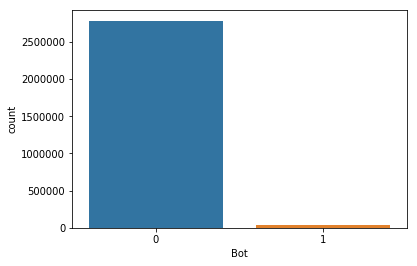

In [13]:
import seaborn as sns
sns.countplot(data=df,x='Bot')

#### There are few ways to balance the classes, I will simply downsample the majority class. This is not the best way to do it but it is less resource intense than other methods.

In [0]:
#Down samplinmg Majority class
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test, = train_test_split(df.drop(['Bot'], axis=1), df['Bot'], test_size=.2)

bot_data = x_train[y_train == 1]
normal_data = x_train[y_train == 0]
normal_data_downsampled = normal_data.sample(n=len(bot_data.index))
x_train = pd.concat([bot_data, normal_data_downsampled])
y_train = y_train[x_train.index]

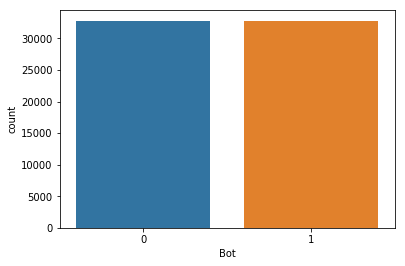

In [15]:
# Lets see the balanced classes
df_temp = x_train.copy()
df_temp["Bot"] = y_train
sns.countplot(data=df_temp,x='Bot')


#### Lets try to run it through a simple model

In [0]:
boost(x_train, y_train, x_test, y_test)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Accuracy: 92.90%
******
[[517409  39276]
 [   812   7431]]
******
7431/8243(90.15%) were correctly identified as bots
39276/556685 (7.06%) were wrongly identified as bots



 ********************************** 

65614/65614 [==============================] - 2s 35us/step
Test score: 0.27471614686464674
Test accuracy: 0.8968360410924257
7373/8154(90.42%) were correctly identified as bots
62326/556774 (11.19%) were wrongly identified as bots


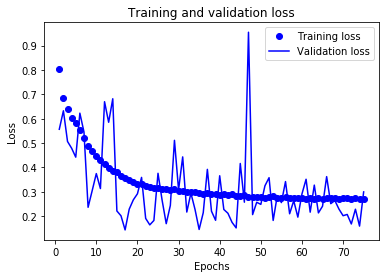

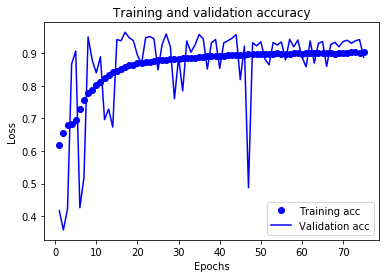


 *************** classifier.evaluate ******************* 



In [0]:
# This creates a simple network of 4 dense layers (3 + output) each with 32 nodes, batch_size=128, epochs=75 (see the function below)
run_network(x_train, y_train, x_test, y_test, 32,0)


#### First run looks pretty nice with a loss of 0.27 and accuracy of 0.89. However, it is considered "unsafe" to use features with relatively high values or of very difference ranges (0-1 and 1-1000). These might prevent the network from converging or may just slow it down. 
#### lets have a look on the numerical features and see if that is the case


In [16]:
#lets describe our numerical features: Dur, TotPkts, SrcBytes

def describe_numerical_features(cols):
  df_numerical = pd.DataFrame({'Name':[x.name for x in cols],
                      'Mean':         [x.mean() for x in cols],
                      'Median':       [x.median() for x in cols],
                      'STD':          [x.std() for x in cols],
                      '25%':          [x.quantile(0.25) for x in cols],
                      '75%':          [x.quantile(0.75) for x in cols],
                      'Min':          [x.min() for x in cols],
                      'Max':          [x.max() for x in cols]})
  display(df_numerical)


describe_numerical_features([df["Dur"],df["TotPkts"],df["SrcBytes"]])
 
  


,Name,Mean,Median,STD,25%,75%,Min,Max
0,Dur,432.205956,0.001194,9.958423e+02,0.000313,9.012607,0.0,3.600031e+03
1,TotPkts,25.479898,2.000000,3.124788e+03,2.000000,4.000000,1.0,2.686731e+06
2,SrcBytes,4155.290128,83.000000,1.858530e+06,78.000000,261.000000,0.0,2.635366e+09


#### As suspected, each feature has a very different range and there is a significant variability and outliers that create an extremely asymmetrical distribution. See, for example, the difference between the mean of the first feature (432) and its median (0.00) which indicates there are quite a few outliers that pull the mean upwards.
#### It is thus recommended to scale the numerical features either by standardization or normalization. 



In [17]:
# I will first try a very common scaler that simply substracts the mean and divides by the sd
from sklearn.preprocessing import StandardScaler

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
print("After Scaling:")
#scale using StandartScaler
x_train_scaled, x_test_scaled = scale(x_train.copy(), x_test.copy(), StandardScaler(), numerical_features)
# Show the main statistics
describe_numerical_features([x_train_scaled[col_name] for col_name in numerical_features])
# fit the model again
#run_network(x_train_scaled, y_train, x_test_scaled, y_test, netsize=32, verbose=0)


After Scaling:


,Name,Mean,Median,STD,25%,75%,Min,Max
0,Dur,-1.271996e-15,-0.303517,1.000008,-0.303596,-0.291624,-0.303597,4.517063
1,TotPkts,-1.097647e-14,-0.033853,1.000008,-0.033853,-0.029440,-0.038266,176.446724
2,SrcBytes,-1.062985e-15,-0.039204,1.000008,-0.039724,-0.031408,-0.045218,197.579872


#### The model performs poorly on the scaled data, at least comparing to its performance on the pre-scaled data.
#### I’m not sure what is the reason that it performs worse, but standard scaling doesnt seem to address the main problems with the numerical data -- e.g.  different ranges and high asymmetry due to outliers. 
#### this can be viewed in the following diagrams. 
#### The StandardScaler does improve some of the issues of the with data, but as the skewness of the data shows the distribution remains highly asymmetrical  




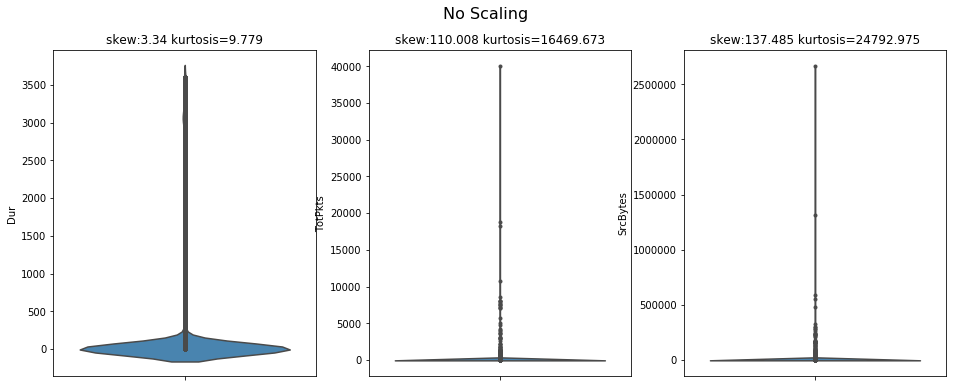

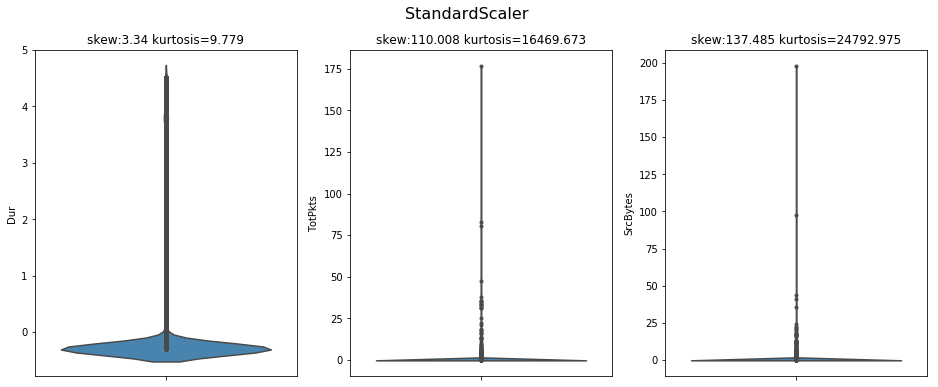

In [18]:
numerical_features = ["Dur","TotPkts","SrcBytes"]
plot_dist(x_train, numerical_features , "No Scaling")
plot_dist(x_train_scaled, numerical_features, "StandardScaler")

#### Now I will try to scale the data using the PowerTransformer which makes the distribution more normal more effectively. 


,Name,Mean,Median,STD,25%,75%,Min,Max
0,Dur,-1.697904e-15,-0.631382,1.000008,-0.721449,1.254558,-0.722520,1.904175
1,TotPkts,-5.925562e-14,-0.404807,1.000008,-0.404807,0.457738,-2.376861,2.231775
2,SrcBytes,-1.351112e-15,-0.449292,1.000008,-0.561249,0.481584,-10.025664,4.388542


,Name,Mean,Median,STD,25%,75%,Min,Max
0,Dur,-1.271996e-15,-0.303517,1.000008,-0.303596,-0.291624,-0.303597,4.517063
1,TotPkts,-1.097647e-14,-0.033853,1.000008,-0.033853,-0.029440,-0.038266,176.446724
2,SrcBytes,-1.062985e-15,-0.039204,1.000008,-0.039724,-0.031408,-0.045218,197.579872


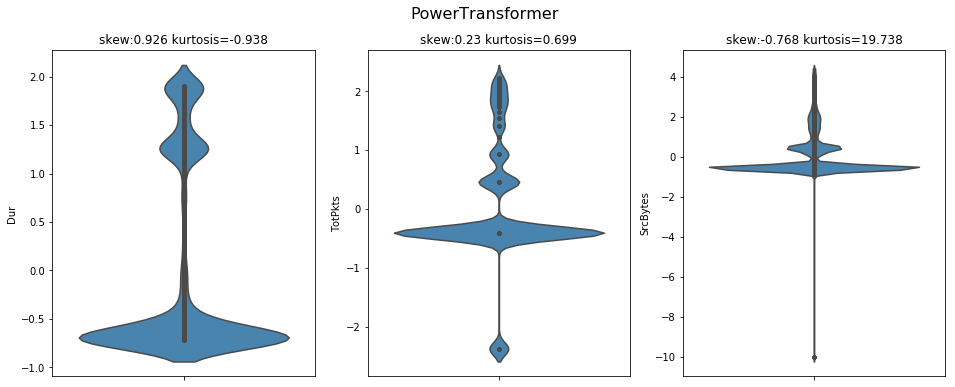

In [22]:
from sklearn.preprocessing import PowerTransformer

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
x_train_normalized, x_test_normalized = scale(x_train.copy(), x_test.copy(), PowerTransformer(), numerical_features)
describe_numerical_features([x_train_normalized[col_name] for col_name in numerical_features])
describe_numerical_features([x_train_scaled[col_name] for col_name in numerical_features])
#plot it
plot_dist(x_train_normalized,numerical_features, "PowerTransformer")



#### The PowerTransformer has significantly "improved" skewness and value range of the data. Now lets try to run the same model on the scaled data


 ********************************** 

65592/65592 [==============================] - 3s 50us/step
Test score: 0.22056790241265764
Test accuracy: 0.9170478107013532
7547/8165(92.43%) were correctly identified as bots
50968/556763 (9.15%) were wrongly identified as bots


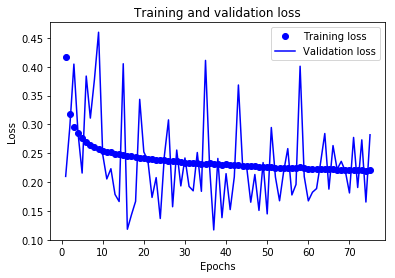

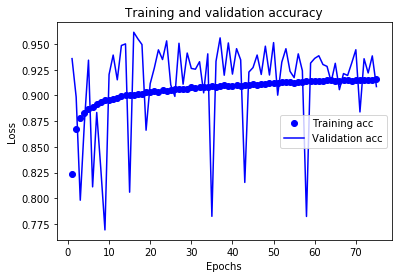

In [27]:
run_network(x_train_normalized, y_train, x_test_normalized, y_test, netsize=32, verbose=0)

W0826 14:27:53.537372 140037850806144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0826 14:27:53.541429 140037850806144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0826 14:27:53.549671 140037850806144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0826 14:27:53.607848 140037850806144 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0826 14:27:53.626917 140037850806144 deprecation_wrappe


 ********************************** 

65592/65592 [==============================] - 3s 49us/step
Test score: 0.5527777456702191
Test accuracy: 0.6515123795621176
7720/8165(94.55%) were correctly identified as bots
362667/556763 (65.14%) were wrongly identified as bots


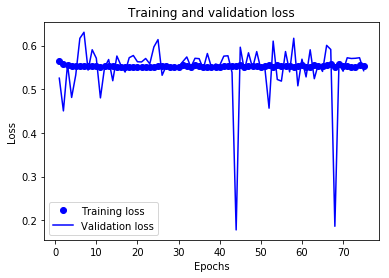

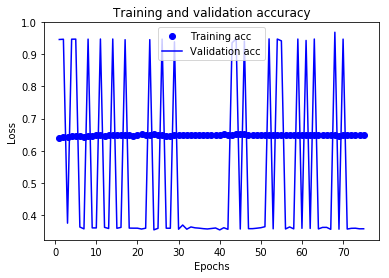

In [21]:
from sklearn.preprocessing import MinMaxScaler

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
x_train_maxed, x_test_maxed = scale(x_train.copy(), x_test.copy(), MinMaxScaler(feature_range=(-2, 2)), numerical_features)
run_network(x_train_maxed,y_train,x_test_maxed,y_test,32,0)

In [0]:

from sklearn.preprocessing import QuantileTransformer

numerical_features = ["Dur", "TotPkts", "SrcBytes"]
x_train_q, x_test_q = scale(x_train.copy(), x_test.copy(), QuantileTransformer(), numerical_features)
run_network(x_train_q,y_train,x_test_q,y_test,32,0)

#### There is some improvement comparing to the first model (loss went down from 0.274 to 0.211 and accuracy when up from 0.896 to 0.920), though it also seem "safer" given the fact that real data may range and vary quite significantly. 

## Helper Functions:Run this first!

In [0]:
# Plotting functions

import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns


def print_perc(tn,tp,fn,fp):
    actual_true = tp + fn
    pr_t = round((tp / actual_true * 100), 2)
    actual_false = tn + fp
    pr_f = round((fp / actual_false * 100), 2)
    print(f"{tp}/{actual_true}({pr_t}%) were correctly identified as bots")
    print(f"{fp}/{actual_false} ({pr_f}%) were wrongly identified as bots")


def plot_loss(history):
    history_dict = history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history.history['acc']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, loss_values, 'bo', label='Training loss')
    plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()   
    
def plot_accuracy(history):
    plt.clf()
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(acc) + 1)  
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_dist(df, features, title):
    f, axs = plt.subplots(ncols=len(features), figsize=(16,6), sharey=False, sharex=False)
    for i, ax in enumerate(axs):
      sns.violinplot(data=df, y=features[i], inner="point", palette="Blues_d",  ax=ax)
      ax.set_title(f"skew:{round(skew(df[features[i]]),3)} kurtosis={round(kurtosis(df[features[i]]),3)}")
    f.suptitle(title, fontsize=16)
    plt.show()



## Training and Scaling Functions

In [6]:

from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.metrics import confusion_matrix

def run_network(xtrain, ytrain, xtest, ytest, netsize=16, verbose=0):

  classifier = Sequential()
  #  First Hidden Layer
  classifier.add(Dense(netsize, activation='relu', input_dim=14))
  # Second  Hidden Layer
  classifier.add(Dense(netsize, activation='relu'))
  # Third  Hidden Layer
  classifier.add(Dense(netsize, activation='relu'))
  # Output Layer
  classifier.add(Dense(1, activation='sigmoid'))
  # Compiling the neural network
  classifier.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
  # Fitting the data to the training dataset
  history = classifier.fit(xtrain,
                         ytrain,
                         batch_size=128,
                         epochs=75,
                         validation_data=(xtest, ytest),
                         verbose=verbose)

  print("\n ********************************** \n")
  score, acc = classifier.evaluate(xtrain, ytrain)
  print('Test score:', score)
  print('Test accuracy:', acc)
  y_pred = classifier.predict(xtest)
  y_pred = (y_pred > 0.5)
  tn, fp, fn, tp = confusion_matrix(ytest, y_pred).ravel()
  print_perc(tn, tp, fn, fp)
  plot_loss(history)
  plot_accuracy(history)
  
  


Using TensorFlow backend.


In [0]:
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler, MinMaxScaler, QuantileTransformer

def scale(xtrain, xtest, transformer, numerical_f):
  if(transformer != None):
    for col in numerical_f:
      data = xtrain[col]
      test_data = xtest[col]
      transformer.fit(data.values.reshape(-1,1))
      xtrain[col] = transformer.transform(data.values.reshape(-1,1))
      xtest[col] = transformer.transform( test_data.values.reshape(-1,1))
  return xtrain, xtest
  
    
  


In [0]:
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import sklearn.metrics as metrics


def boost(train_data, train_targets, test_data, test_targets):
  model = XGBClassifier()
  model.fit(train_data, train_targets)
  print(model)
  predictions_raw = model.predict(test_data)
  predictions = [round(value) for value in predictions_raw]
  # evaluate predictions
  accuracy = accuracy_score(test_targets, predictions)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print("******")
  cm = confusion_matrix(test_targets, predictions_raw)
  print(cm)
  print("******")
  tn, fp, fn, tp = confusion_matrix(test_targets, predictions_raw).ravel()
  print_perc(tn,tp,fn,fp)
  

In [0]:
def boost_fit(alg, x_train, y_train, xtest, ytest, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(x_train.values, label=y_train.values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds, metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(x_train, y_train,eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(x_train)
    dtrain_predprob = alg.predict_proba(x_train)[:,1]
        
    #Print model report:
    print ("\nModel Report")
    print ("Accuracy : %.4g" % metrics.accuracy_score(y_train.values, dtrain_predictions))
    print ("AUC Score (Train): %f" % metrics.roc_auc_score(y_train, dtrain_predprob))


    # ==>
    #Predict testing set:
    dtrain_predictions = alg.predict(xtest)
    dtrain_predprob = alg.predict_proba(xtest)[:,1]
    print ("AUC Score (Test): %f" % metrics.roc_auc_score(ytest, dtrain_predprob))
                    
    feat_imp = pd.Series(alg.get_booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

    print("Now test it ==>")
    predictions_raw = alg.predict(xtest)
    predictions = [round(value) for value in predictions_raw]
    # evaluate predictions
    accuracy = accuracy_score(ytest, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))
    print("******")
    cm = confusion_matrix(ytest, predictions_raw)
    print(cm)
    print("******")
    tn, fp, fn, tp = confusion_matrix(ytest, predictions_raw).ravel()
    print_perc(tn,tp,fn,fp)

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

#Choose all predictors except target & IDcols



In [10]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
!pip install seaborn


Model Report
Accuracy : 0.9503
AUC Score (Train): 0.990302
AUC Score (Test): 0.984555
Now test it ==>
Accuracy: 92.96%
******
[[517377  39307]
 [   466   7778]]
******
7778/8244(94.35%) were correctly identified as bots
39307/556684 (7.06%) were wrongly identified as bots


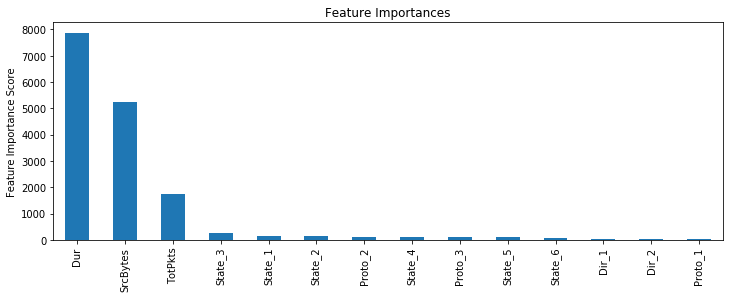

In [0]:


xgb1 = XGBClassifier(
 learning_rate = 0.1,
 n_estimators=1000,
 max_depth=5,
 min_child_weight=1,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.8,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,
 seed=27)
boost_fit(xgb1, x_train, y_train, x_test, y_test)

In [0]:
len(x_test.index)

564928

data size:1412318
      Name       Mean  Median      Max  ...  75%   95%   98%    99%
0  TotPkts  25.275465     2.0  1565374  ...  4.0  25.0  57.0  118.0

[1 rows x 10 columns]
0  Name      TotPkts
   Mean      25.2755
   Median          2
   Max       1565374
   STD        2708.8
   25%             2
   75%             4
   95%            25
   98%            57
   99%           118
dtype: object


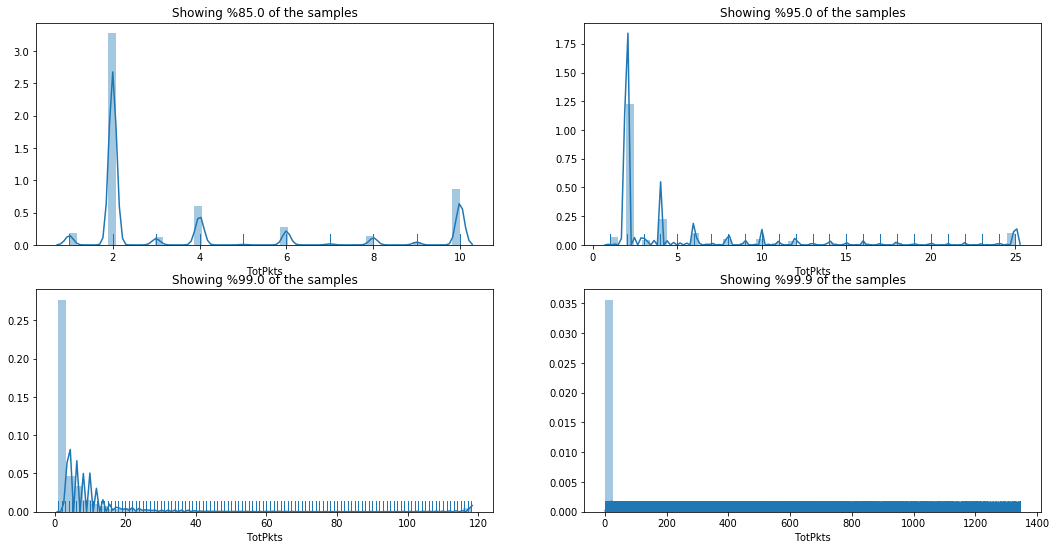

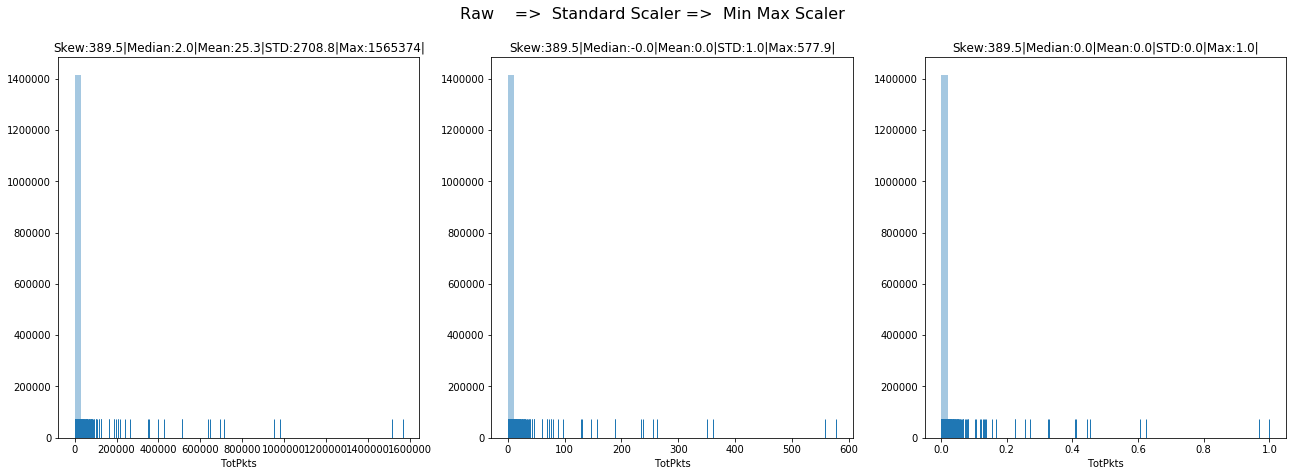

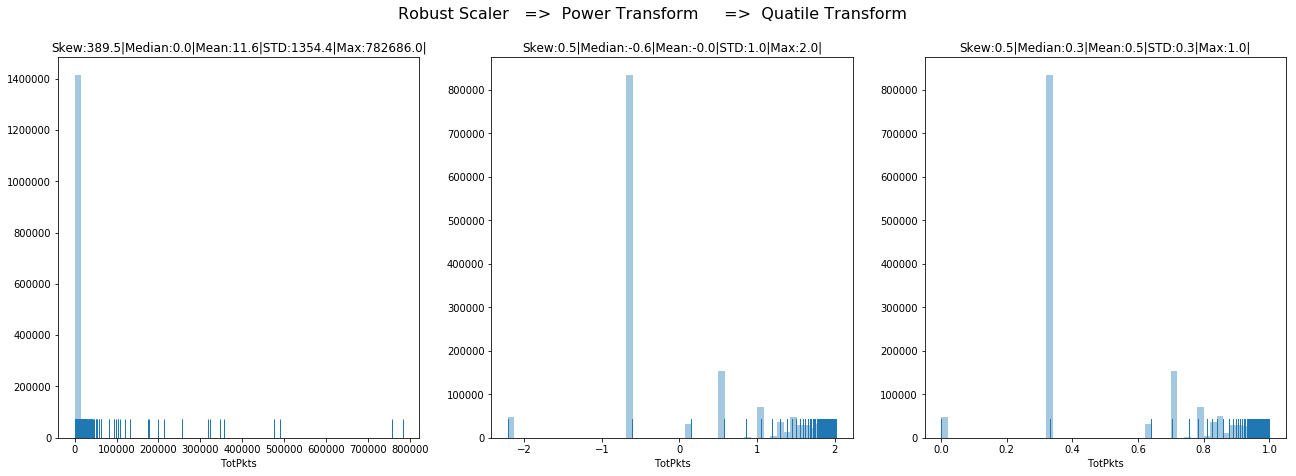

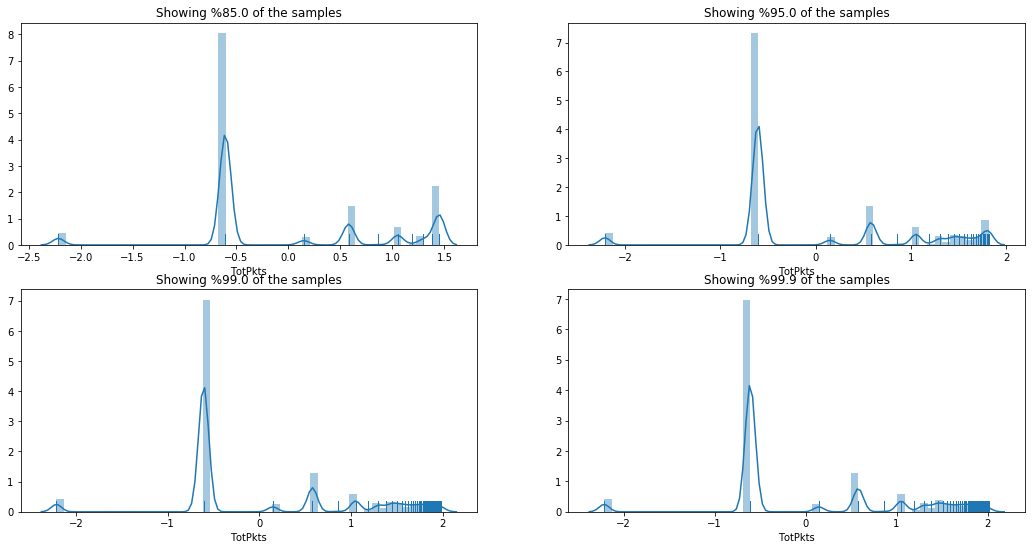

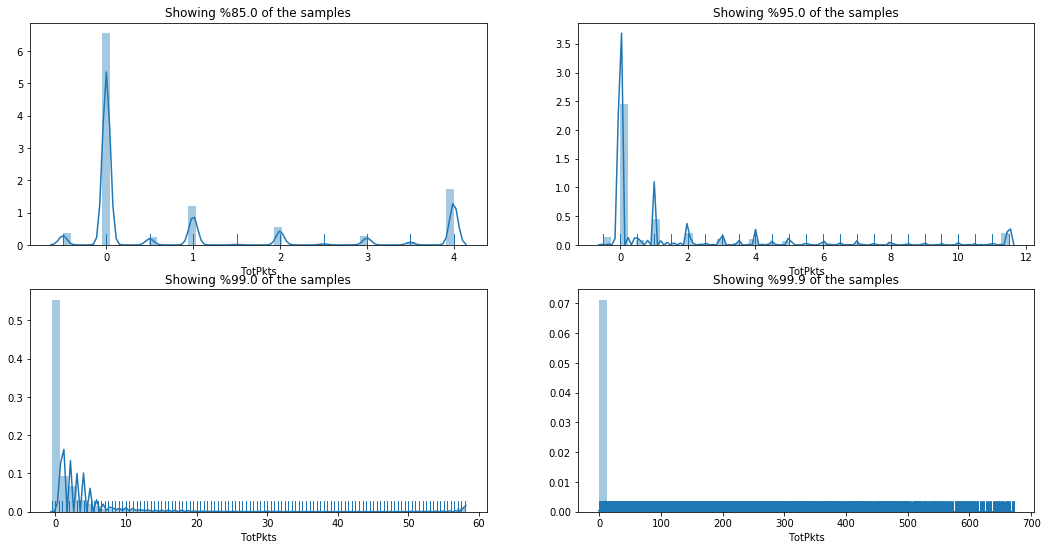

"\ndf = df[df[tested_feature] < 4000]\nfig, ax = plt.subplots(figsize=(16,8))\nsns.swarmplot(x='Bot', y=tested_feature, data=df, ax=ax)\n#ax.scatter(df['Bot'], df[tested_feature])\n#ax.set_xlabel('Bot')\n#ax.set_ylabel(tested_feature)\nplt.show()\n"

In [33]:
import pandas as pd
import numpy as np

df = df.sample(frac=0.5)
print(f"data size:{len(df.index)}")

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, \
 StandardScaler, RobustScaler, MinMaxScaler


def plot_distribution(n_feature_1, n_feature_2, n_feature_3, title):
    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(22,7), sharey=False, sharex=False)
    sns.violinplot(data=n_feature_1,  inner="points", ax=ax1) #sns.distplot(n_feature_1, ax=ax1)
    sns.violinplot(data=n_feature_2,  inner="points", ax=ax2) #sns.distplot(n_feature_2, ax=ax2)
    sns.violinplot(data=n_feature_3,  inner="points", ax=ax3) #sns.distplot(n_feature_3, ax=ax3)
    ax1.set_title(get_description_str(n_feature_1))
    ax2.set_title(get_description_str(n_feature_2))
    ax3.set_title(get_description_str(n_feature_3))
    f.suptitle(title, fontsize=16)
    plt.show()
    
def plot_distribution_hist(n_feature_1, n_feature_2, n_feature_3, title):
    f, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(22,7), sharey=False, sharex=False)
    sns.distplot(n_feature_1, ax=ax1, kde=False, rug=True)
    sns.distplot(n_feature_2, ax=ax2, kde=False, rug=True)
    sns.distplot(n_feature_3, ax=ax3, kde=False, rug=True)
    ax1.set_title(get_description_str(n_feature_1))
    ax2.set_title(get_description_str(n_feature_2))
    ax3.set_title(get_description_str(n_feature_3))
    f.suptitle(title, fontsize=16)
    plt.show()

def get_description_str(feature):
   _str = f"Skew:{round(skew(feature),1)}|"
 #  _str += f"Min:{round(feature.min(),1)}|"
#   _str += f"Max:{round(feature.max(),1)}|"
   _str += f"Median:{round(feature.median(),1)}|"
   _str += f"Mean:{round(feature.mean(),1)}|"
   _str += f"STD:{round(feature.std(),1)}|"
   _str += f"Max:{round(feature.max(),1)}|"
    
   return _str
    
def transform_and_plot(f_Dur, f_Pkts, f_Bytes, df, transformer, title):
    for feature in [f_Dur, f_Pkts, f_Bytes]:
        data = feature.values.reshape(-1,1)
        df[feature.name] = transformer.fit_transform(data)
        
    #plot_distribution(df[f_Dur.name], df[f_Pkts.name], df[f_Bytes.name], title)
    #plot_distribution_hist(df[f_Dur.name], df[f_Pkts.name], df[f_Bytes.name], title)
    
def transform(_df, feature_name, transformer):
    data = _df[feature_name].values.reshape(-1,1)
    _df[feature_name] = transformer.fit_transform(data)
    return  _df[feature_name]


tested_feature = "TotPkts"
tested_series = df[tested_feature]
info = pd.DataFrame({'Name':[tested_series.name],
                   'Mean':[tested_series.mean()],
                   'Median':[tested_series.median()],
                   'Max':[tested_series.max()],
                   'STD':[tested_series.std()],
                   '25%':[tested_series.quantile(0.25)],
                   '75%':[tested_series.quantile(0.75)],
                   '95%':[tested_series.quantile(0.95)],
                   '98%':[tested_series.quantile(0.98)],
                   '99%':[tested_series.quantile(0.99)]})
print(info)
print(info.stack())


def plot_distribution_quantile (series, p_1, p_2, p_3, p_4):
    line_start = series.quantile(0.001)
    line_a = series.quantile(p_1)
    line_b = series.quantile(p_2)
    line_c = series.quantile(p_3)
    line_d = series.quantile(p_4)
    f, axes = plt.subplots(ncols=2, nrows=2, figsize=(18,9), sharey=False, sharex=False)
    sns.distplot(np.clip(series, line_start, line_a), ax=axes[0,0], kde=True, rug=True)
    sns.distplot(np.clip(series, line_start, line_b), ax=axes[0,1], kde=True, rug=True)
    sns.distplot(np.clip(series, line_start, line_c), ax=axes[1,0], kde=True, rug=True)
    sns.distplot(np.clip(series, line_start, line_d), ax=axes[1,1], kde=True, rug=True)
    axes[0,0].set_title(f"Showing %{p_1 * 100} of the samples")
    axes[0,1].set_title(f"Showing %{p_2 * 100} of the samples")
    axes[1,0].set_title(f"Showing %{p_3 * 100} of the samples")
    axes[1,1].set_title(f"Showing %{p_4 * 100} of the samples")
    plt.show()

plot_distribution_quantile (tested_series, 0.85, 0.95, 0.99, 0.999)

bytes_series_normal = transform(df.copy(),tested_feature, StandardScaler())
bytes_series_power = transform(df.copy(),tested_feature, PowerTransformer())
bytes_series_minmax = transform(df.copy(),tested_feature, MinMaxScaler())
bytes_series_quantile= transform(df.copy(),tested_feature, QuantileTransformer())
bytes_series_robust= transform(df.copy(),tested_feature, RobustScaler())

plot_distribution_hist(
    df[tested_feature],
    bytes_series_normal,
    bytes_series_minmax,
    "Raw    =>  Standard Scaler =>  Min Max Scaler")
plot_distribution_hist(
   bytes_series_robust,
   bytes_series_power,
    bytes_series_quantile,
    "Robust Scaler   =>  Power Transform     =>  Quatile Transform")


plot_distribution_quantile (bytes_series_power, 0.85, 0.95, 0.99, 0.999)
plot_distribution_quantile (bytes_series_robust, 0.85, 0.95, 0.99, 0.999)



df = df[df[tested_feature] < 4000]
fig, ax = plt.subplots(figsize=(16,8))
sns.swarmplot(x='Bot', y=tested_feature, data=df, ax=ax)
#ax.scatter(df['Bot'], df[tested_feature])
#ax.set_xlabel('Bot')
#ax.set_ylabel(tested_feature)
plt.show()


#f_Dur = df['Dur']
#f_Pkts = df['TotPkts']
#f_Bytes = df['SrcBytes']

#plot_distribution(f_Dur, f_Pkts, f_Bytes, "Raw Distribution")
#plot_distribution_hist(f_Dur, f_Pkts, f_Bytes, "Raw Distribution")
#transform_and_plot(f_Dur, f_Pkts, f_Bytes, df.copy(), StandardScaler(), "StandardScaler")
#transform_and_plot(f_Dur, f_Pkts, f_Bytes, df.copy(), PowerTransformer(), "PowerTransformer")
#transform_and_plot(f_Dur, f_Pkts, f_Bytes, df.copy(), QuantileTransformer(), "QuantileTransformer")


#StandardScaler








  
 











